<h1>Regresión logística multiclase</h1>

La regresión logística multiclase es un modelo supervisado de clasificación que se usa cuando la variable objetivo tiene más de dos categorías.

In [394]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from pathlib import Path
import time
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve, 
    auc
)

In [356]:
# Cargar x e y provenientes del preprocesado.
X_train = pd.read_csv("../../../data/x_train.csv")
X_test = pd.read_csv("../../../data/x_test.csv")
x_train_scaled  = pd.read_csv("../../../data/x_train_scaled.csv")
x_test_scaled  = pd.read_csv("../../../data/x_test_scaled.csv")
y_train = pd.read_csv("../../../data/y_train.csv")
y_test = pd.read_csv("../../../data/y_test.csv")

En este caso, la variable objetivo es 'newoff' --> tipo de delito. El tipo de delito puede ser: 
- Agresión sexual
- Robo
- Agresión agravada
- Agresión simple
- Robo personal o hurto

Las variables que se van a usar para predecir el target son:

In [357]:
print(f"Variables predictoras:\n")
print(X_train.describe().T)

Variables predictoras:

                                                    count unique    top   freq
ager_18-24                                          44702      2  False  36809
ager_25-34                                          44702      2  False  35387
ager_35-49                                          44702      2  False  33479
ager_50-64                                          44702      2  False  37721
ager_65+                                            44702      2  False  42535
sex_Male                                            44702      2   True  22657
race_ethnicity_Non-Hispanic American Indian/Ala...  44702      2  False  44208
race_ethnicity_Non-Hispanic Asian/Native Hawaii...  44702      2  False  43616
race_ethnicity_Non-Hispanic black                   44702      2  False  39169
race_ethnicity_Non-Hispanic more than one race      44702      2  False  43735
race_ethnicity_Non-Hispanic white                   44702      2   True  30622
hincome1_$25,000 to $34,999 

<h2>Funciones</h2>

1. Función para calcular las métricas

Métricas:

- Accuracy → porcentaje de predicciones correctas sobre todas las clases.
- Recall → qué porcentaje de los casos reales positivos (de una clase) el modelo logra identificar correctamente.
- F1 → promedio armónico entre precisión (precision) y recall.

In [358]:
def calcular_metricas(modelo, x_train_scaled, y_train, x_test_scaled, y_test):


    """
    Calcula y muestra las métricas principales de un modelo de clasificación multiclase.


    Parámetros:
    -----------
    modelo : objeto entrenado
        Modelo de clasificación ya entrenado (por ejemplo, DecisionTreeClassifier, RandomForestClassifier, etc.).
    x_train : array-like o DataFrame
        Datos de entrenamiento.
    y_train : array-like
        Etiquetas verdaderas del conjunto de entrenamiento.
    x_test : array-like o DataFrame
        Datos de prueba.
    y_test : array-like
        Etiquetas verdaderas del conjunto de prueba.


    Métricas calculadas e impresas:
    -------------------------------
    - Accuracy en entrenamiento
    - Accuracy en test
    - Recall en entrenamiento (promedio ponderado)
    - Recall en test (promedio ponderado)
    - F1-score en entrenamiento (promedio ponderado)
    - F1-score en test (promedio ponderado)


    Retorna:
    --------
    Tuple de 6 floats:
        (accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test)


    Ejemplo de uso:
    ----------------
    acc_train, acc_test, rec_train, rec_test, f1_train, f1_test = calcular_metricas(
        modelo_base, x_train, y_train, x_test, y_test
    )
    """
    #Predicciones
    y_pred_train = modelo.predict(x_train_scaled)
    y_pred_test = modelo.predict(x_test_scaled)


    #Calcular las metricas


    # Accuracy en entrenamiento
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Accuracy en test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Recall en entrenamiento
    recall_train = recall_score(y_train, y_pred_train,average='macro')
    # Recall en test
    recall_test = recall_score(y_test, y_pred_test, average='macro')
    # F1-score en entrenamiento (balance entre precisión y recall)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    # F1-score en test
    f1_test = f1_score(y_test, y_pred_test, average='macro')

    print("="*60)
    print("TRAIN")
    print("="*60)
    print(f"Accuracy (train): {accuracy_train:.4f}")
    print(f"Recall (train): {recall_train:.4f}")
    print(f"F1-score (train): {f1_train:.4f}")
    print("="*60)
    print("TEST")
    print("="*60)
    print(f"Accuracy (test): {accuracy_test:.4f}")
    print(f"Recall (test): {recall_test:.4f}")
    print(f"F1-score (test): {f1_test:.4f}")


    return y_pred_train,y_pred_test,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test


2. Función para guardar las métricas.

In [359]:
ARCHIVO_METRICAS = Path('metrics_regresion_logistica.csv')

COLUMNAS = [
    "modelo", "experimento", "accuracy_train", "accuracy_test",
    "recall_train_weighted", "recall_test_weighted", "f1_train_weighted","f1_test_weighted" "tiempo_entrenamiento_seg", "overfitting", "observaciones"
]


def agregar_metrica(modelo, experimento, accuracy_train, accuracy_test,
                    recall_train_weighted,recall_test_weighted, f1_train_weighted, f1_test_weighted,
                    tiempo_entrenamiento_seg, overfitting, observaciones,
                    archivo=ARCHIVO_METRICAS):
    """
    Agrega una nueva fila de métricas al archivo CSV.
    Si el archivo no existe, lo crea con las columnas estándar.
    """


    # Crear DataFrame de la nueva fila
    nueva_fila = pd.DataFrame([{
        "modelo": modelo,
        "experimento": experimento,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "recall_train_weighted": recall_train_weighted,
        "recall_test_weighted": recall_test_weighted,
        "f1_train_weighted": f1_train_weighted,
        "f1_test_weighted": f1_test_weighted,
        "tiempo_entrenamiento_seg": tiempo_entrenamiento_seg,
        "overfitting": overfitting,
        "observaciones": observaciones
    }])


    # Si el archivo ya existe, cargarlo y agregar la fila
    if archivo.exists():
        df = pd.read_csv(archivo)
        df = pd.concat([df, nueva_fila], ignore_index=True)
    else:
        df = nueva_fila


    # Guardar el archivo actualizado
    df.to_csv(archivo, index=False)
    print(f"Métrica agregada correctamente a {archivo}")

<h2>Modelo 1: Baseline</h2>

El modelo baseline (modelo base o de referencia) es el modelo sin ajustes especiales ni balanceo de clases. Sirve como punto de partida para comparar el rendimiento de las siguientes versiones (Modelo 2 y Modelo 3).

<h3>Parámetros de entrada</h3>

- multi_class='multinomial' --> La regresión logística multinomial aprende una serie de coeficientes (pesos) para cada variable predictora y para cada clase. El modelo  estima la probabilidad de que una observación \( X \) pertenezca a una clase \( k \) (de entre \( K \) clases posibles) mediante la función *softmax*:

    $$
    P(y = k \mid X) = \frac{e^{\beta_k^\top X}}{\sum_{j=1}^{K} e^{\beta_j^\top X}}
    $$

    Donde:
    - K es el número de clases.  
    - βk​ son los coeficientes asociados a la clase \(k\).  
    - X es el vector de características de la observación.




- max_iter=1000 --> Aumenta el número máximo de iteraciones, importante para asegurar que el modelo converge cuando hay muchos features (tras el one-hot encoding).
- random_state=42 --> Fija la semilla aleatoria para reproducibilidad.

In [405]:
baseline_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
# Calcular el tiempo que tarda en entrenar
inicio = time.time()
baseline_model.fit(x_train_scaled, y_train)
fin = time.time()
tiempo_entrenamiento = fin - inicio

c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<h3>Métricas</h3>

In [406]:
#Calcular las metricas del modelo
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas(baseline_model, x_train_scaled, y_train, x_test_scaled, y_test)

TRAIN
Accuracy (train): 0.6240
Recall (train): 0.2091
F1-score (train): 0.1720
TEST
Accuracy (test): 0.6240
Recall (test): 0.2083
F1-score (test): 0.1704


- Accuracy (0.6240)

El modelo acierta aproximadamente el 62 % de las veces.

Puede parecer aceptable a primera vista, pero en un problema multiclase desbalanceado, el accuracy puede ser engañoso: si una clase es muy frecuente, el modelo puede acertar mucho simplemente prediciendo siempre esa clase.

Además, el hecho de que el accuracy sea igual en train y test sugiere que el modelo no está sobreajustando, pero también no está aprendiendo patrones profundos (puede estar “atascado” en un nivel muy básico).

- Recall (≈0.21)

El modelo solo recupera correctamente el 21 % de las instancias reales en promedio entre clases.

Esto indica que muchas clases no están siendo reconocidas correctamente, especialmente las minorías.

Un recall bajo en multiclase significa que el modelo deja escapar la mayoría de las verdaderas etiquetas (predice otras en su lugar).

- F1-score (≈0.17)

Es bajo porque el F1 combina precisión y recall.

Un valor de 0.17 indica que el modelo no está equilibrando bien entre aciertos y errores.

En este caso, confirma que el modelo no está clasificando bien ninguna clase minoritaria.

**Conclusión**

El modelo baseline está funcionando como un punto de partida, pero su desempeño es muy limitado:

Está sesgado hacia las clases más frecuentes.

No capta las relaciones reales entre las variables predictoras y las etiquetas.

Los valores iguales entre train y test sugieren que no hay overfitting, pero también que el modelo es demasiado simple o mal calibrado para los datos.

<h3>Visualizaciones</h3>

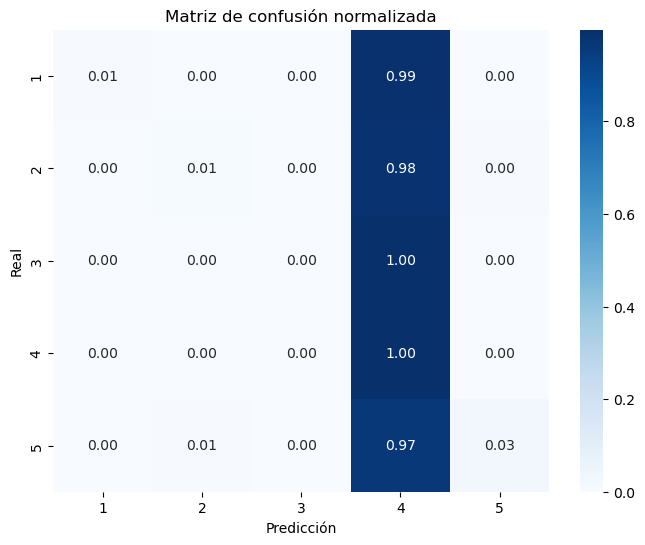

In [407]:
# Obtener las clases reales del dataset (ordenadas)
clases = sorted(y_test['newoff'].unique())  # ajusta 'newoff' a tu columna de etiquetas

# Matriz de confusión normalizada usando test
cm = confusion_matrix(y_test, y_pred_test, labels=clases, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión normalizada")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

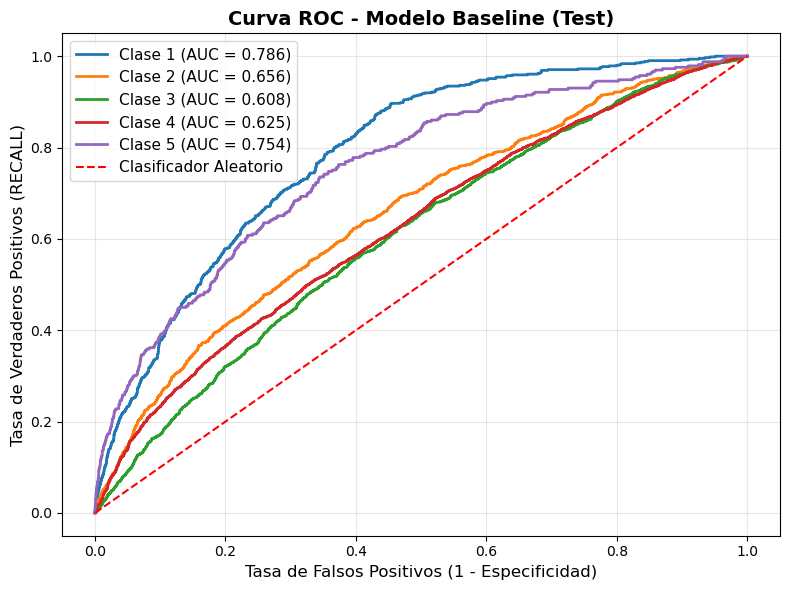

In [395]:
# Binarizar las clases (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])  # ajusta según tus clases reales

# Obtener las probabilidades de predicción del modelo
y_proba = baseline_model.predict_proba(x_test_scaled)

# Graficar curva ROC para cada clase
plt.figure(figsize=(8, 6))

for i, clase in enumerate([1, 2, 3, 4, 5]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'Clase {clase} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Clasificador Aleatorio')
plt.title('Curva ROC - Modelo Baseline (Test)', fontsize=14, fontweight='bold')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (RECALL)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Conclusión</h3>


In [409]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           1       0.50      0.01      0.01       610
           2       0.48      0.01      0.02      1159
           3       0.33      0.00      0.00      2115
           4       0.62      1.00      0.77      6963
           5       0.43      0.03      0.05       329

    accuracy                           0.62     11176
   macro avg       0.47      0.21      0.17     11176
weighted avg       0.54      0.62      0.48     11176



El modelo tiende claramente a favorecer la clase 4, que es la clase mayoritaria en el conjunto de datos.
Esto sugiere que no está aprendiendo patrones significativos entre las variables predictoras y las etiquetas, sino que predice la clase 4 por defecto para maximizar el número de aciertos globales (reflejado en un accuracy aparentemente alto).

En la curva ROC por clase se observa que el modelo intenta identificar parcialmente la clase 1, mostrando un leve aprendizaje en esa categoría, pero ignora casi por completo las demás clases, especialmente la 4, donde prácticamente no realiza esfuerzo de discriminación.

En resumen, el modelo baseline está sesgado hacia la clase mayoritaria y carece de capacidad para distinguir correctamente entre las distintas categorías, limitándose a reproducir la distribución desequilibrada del dataset en lugar de aprender relaciones reales.

<h3>Guardar métricas</h3>

In [364]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Regresión Logística', 'Base',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,'Si','lalala')

Métrica agregada correctamente a metrics_regresion_logistica.csv


<h2>Modelo 2: Balanceo de clases</h2>

Primero quiero saber si mi tarjet está desbalanceado. Para ello, primero cuento los valores de la variable 'newoff' y los grafico para entender mejor los datos.

In [365]:
# Contar ejemplos por clase
y_train.value_counts()

newoff
4         27850
3          8460
2          4634
1          2440
5          1318
Name: count, dtype: int64

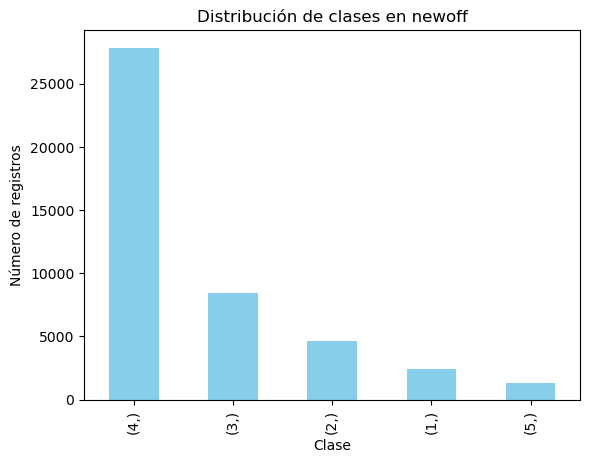

In [366]:
# Gráfico para visualizar la distribución de las clases del target
y_train.value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribución de clases en newoff")
plt.xlabel("Clase")
plt.ylabel("Número de registros")
plt.show()

EL tarjet 'newoff' esta muy desbalanceado de tal manera que: 
- Clase 4 --> 64 % de los casos
- Clase 5 --> apenas 3 %

Es decir, una diferencia de casi 20 × entre clases.

<h3>Parámetros de entrada</h3>

- class_weight = 'balanced' --> Como las clases están desbalanceadas uso el parametro para que ajuste automaticamente los pesos de cada clase.
- multi_class='multinomial' --> Como es una regresión logística multiclase, una sola función softmax conjunta calcula la probabilidad de cada clase al mismo tiempo.

    Sin estas dos correciones, la regresión logística:
    - Aprendería a predecir casi siempre la clase 4,
    - Obtendría una accuracy alta pero engañosa,
    - Y fallaría casi siempre con las clases minoritarias (1 y 5).

- max_iter=1000 --> Aumenta el número máximo de iteraciones, importante para asegurar que el modelo converge cuando hay muchos features (tras el one-hot encoding).
- random_state=42 --> Fija la semilla aleatoria para reproducibilidad.

In [412]:
# Modelo baseline
balanced_model  = LogisticRegression(
    class_weight='balanced',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
# Calcular el tiempo que tarda en entrenar
inicio = time.time()
balanced_model.fit(X_train, y_train)
fin = time.time()
tiempo_entrenamiento = fin - inicio

c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<h3>Métricas</h3>

In [413]:
#Calcular las metricas del modelo
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas(balanced_model, x_train_scaled, y_train, x_test_scaled, y_test)

TRAIN
Accuracy (train): 0.1637
Recall (train): 0.3374
F1-score (train): 0.1607
TEST
Accuracy (test): 0.1645
Recall (test): 0.3310
F1-score (test): 0.1590


- Accuracy (≈0.1645 en test, 0.1637 en train)

El modelo acierta aproximadamente el 16 % de las veces.

Este valor es muy bajo, pero tiene sentido porque el dataset es muy desbalanceado: la clase 4 representa la mayoría de los casos (≈28.000 de 44.702).

A diferencia del baseline, el modelo ahora intenta balancear las clases usando class_weight='balanced', por lo que no se centra únicamente en la clase mayoritaria.

El hecho de que los valores de train y test sean casi idénticos indica que no hay overfitting, pero el rendimiento general sigue siendo limitado.

- Recall (≈0.3310 en test, 0.3374 en train)

El recall ha subido respecto al baseline (de ≈0.21 a ≈0.33), lo que significa que el modelo reconoce mejor las clases minoritarias.

Un recall de ~0.33 indica que, en promedio, el modelo logra recuperar correctamente alrededor de un tercio de las instancias reales de cada clase.

Aunque sigue siendo bajo, es una mejora notable respecto al baseline, donde las clases minoritarias eran prácticamente ignoradas.

- F1-score (≈0.1590 en test, 0.1607 en train)

El F1-score sigue siendo bajo, lo que refleja que aunque el recall ha mejorado, el modelo todavía comete muchos errores en precisión.

Esto se debe a que el modelo ahora predice más clases minoritarias, pero no siempre acierta exactamente cuál, generando un equilibrio bajo entre precisión y recall.

**Conclusión**

El modelo Balanced mejora la equidad entre clases, especialmente las minoritarias, comparado con el baseline.

Aumenta el recall y evita el sesgo hacia la clase mayoritaria (clase 4), pero todavía no es suficiente para lograr un buen rendimiento general.

La baja accuracy y F1 muestran que las relaciones entre variables predictoras y etiquetas aún no se captan completamente.

<h3>Visualizaciones</h3>

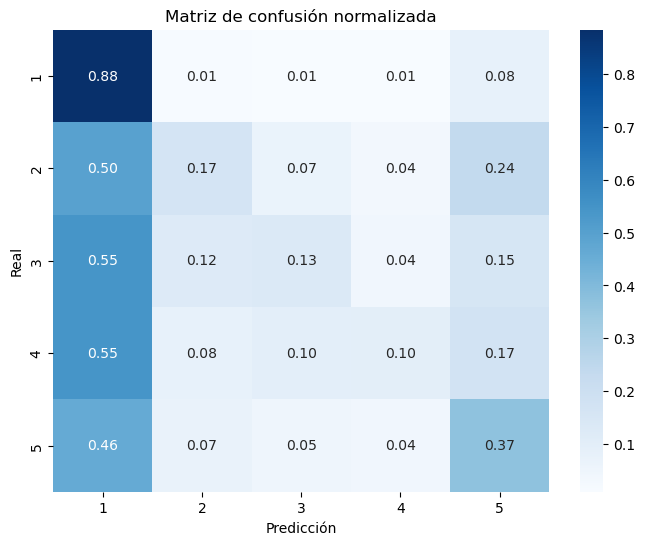

In [414]:
# Obtener las clases reales del dataset (ordenadas)
clases = sorted(y_test['newoff'].unique())  # ajusta 'newoff' a tu columna de etiquetas

# Matriz de confusión normalizada usando test
cm = confusion_matrix(y_test, y_pred_test, labels=clases, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión normalizada")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

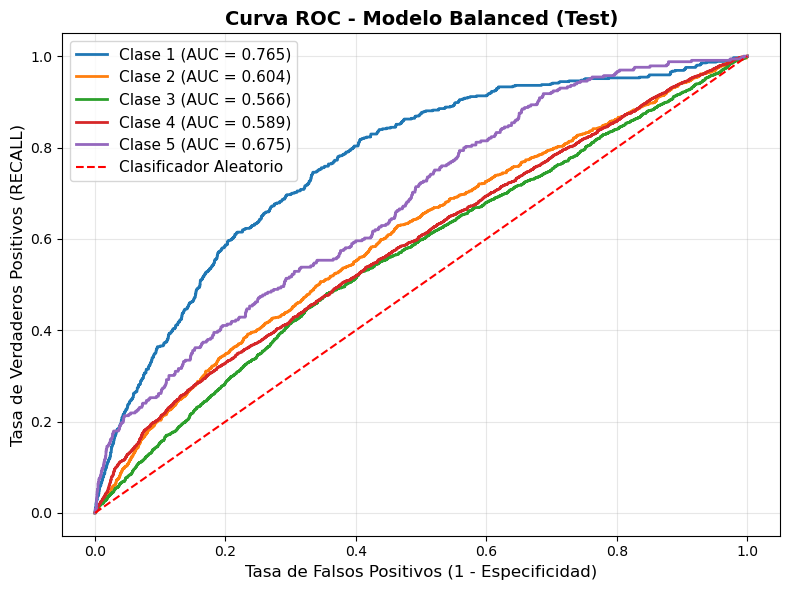

In [415]:
# Binarizar las clases (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])  # ajusta según tus clases reales

# Obtener las probabilidades de predicción del modelo
y_proba = balanced_model.predict_proba(x_test_scaled)

# Graficar curva ROC para cada clase
plt.figure(figsize=(8, 6))

for i, clase in enumerate([1, 2, 3, 4, 5]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'Clase {clase} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Clasificador Aleatorio')
plt.title('Curva ROC - Modelo Balanced (Test)', fontsize=14, fontweight='bold')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (RECALL)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Conclusión</h3>

In [416]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           1       0.09      0.88      0.16       610
           2       0.18      0.17      0.17      1159
           3       0.27      0.13      0.18      2115
           4       0.82      0.10      0.18      6963
           5       0.06      0.37      0.11       329

    accuracy                           0.16     11176
   macro avg       0.28      0.33      0.16     11176
weighted avg       0.59      0.16      0.18     11176



En este modelo, al aplicar el balanceo de clases, se observa un cambio en el sesgo de predicción: el modelo pasa de centrarse casi exclusivamente en la clase 4 (la mayoritaria) a sobrerrepresentar la clase 1, que originalmente contaba con pocos datos.

Esto ocurre porque el balanceo asigna el mismo peso a todas las clases, independientemente de su frecuencia real en los datos. Como consecuencia, el modelo intenta compensar el desequilibrio y termina prediciendo en exceso las clases minoritarias, especialmente la 1, aunque esto no refleja correctamente la distribución real del problema.

En resumen, aunque el balanceo mejora el recall en clases minoritarias, reduce la precisión global y genera predicciones menos realistas, ya que el modelo pierde la referencia de la frecuencia natural de las clases.

<h3>Guardar métricas</h3>

In [371]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Regresión Logística', 'Base',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,'Si','lalala')

Métrica agregada correctamente a metrics_regresion_logistica.csv


<h2>Modelo 3: ajuste con GridSearchCV</h2>

El Modelo 3 es una versión optimizada de la regresión logística multinomial, en la que no solo entrenamos un modelo directamente, sino que buscamos la mejor combinación de hiperparámetros para maximizar su rendimiento.

<h3>Parámetros de entrada</h3>

- C: Es la Regularización inversa --> Controla qué tan “flexible” es el modelo. 
    - Si los valores son bajos: El modelo tiene menos libertad para ajustar los datos. Se fuerza a mantener los coeficientes más pequeños. Esto evita que se aprenda demasiado de los ruidos o excepciones --> menos overfitting. Es como ponerle “barrera” al modelo: no puede ir demasiado al detalle.
    - Si los valores son altos -->El modelo tiene más libertad para ajustarse a los datos. Puede aprender patrones más complejos. Pero si se pasa, puede memorizar los datos de entrenamiento y fallar en nuevos datos --> overfitting. Es como quitarle el freno y dejar que corra libremente.
- penalty: Tipo de regularización. 'l2' penaliza coeficientes grandes, ayudando a reducir overfitting.
- solver: Algoritmo para optimizar los coeficientes.
    - 'lbfgs' → rápido y estable para problemas multiclase.
    - 'newton-cg' → bueno para problemas grandes y multiclase.
    - 'saga' → compatible con regularización L1/L2 y datos grandes.

- multi_class='multinomial' --> mantenemos la aplicación de la función softmax.

In [389]:
param_grid = {
    'C': [1, 10, 20, 25],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'multi_class': ['multinomial'],
    'class_weight': ['balanced']
}

grid_model = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
inicio = time.time()
grid_model.fit(x_train_scaled, y_train)
fin = time.time()
tiempo_entrenamiento = fin - inicio

best_model = grid_model.best_estimator_

print("Mejor combinación de hiperparámetros:")
print(grid_model.best_params_)

c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor combinación de hiperparámetros:
{'C': 1, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


c:\Users\iabd\AppData\Local\anaconda3\envs\Primero\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<h3>Métricas</h3>

In [418]:
#Calcular las metricas del modelo
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas(best_model, x_train_scaled, y_train, x_test_scaled, y_test)

TRAIN
Accuracy (train): 0.2771
Recall (train): 0.3927
F1-score (train): 0.2401
TEST
Accuracy (test): 0.2755
Recall (test): 0.3884
F1-score (test): 0.2383


- Accuracy (≈0.277)

El modelo acierta aproximadamente 27–28 % de las veces.

Dado que algunas clases son mucho más frecuentes que otras (por ejemplo, clase 4 con 27 850 ejemplos vs clase 5 con 1 318), un accuracy relativamente bajo indica que el modelo no está simplemente "copiando" la clase mayoritaria.

El hecho de que el accuracy sea muy similar en train y test sugiere que no hay overfitting.

- Recall (≈0.39)

El recall promedio es de ≈39 %, lo que indica que el modelo identifica correctamente menos de la mitad de las instancias reales.

- F1-score (≈0.24)

El F1-score combina precisión y recall, y un valor de 0.24 indica que el balance entre aciertos y errores sigue siendo bajo.

**Conclusión**

Este modelo mejora el reconocimiento de las clases minoritarias en comparación con el baseline.

Todavía hay un desempeño global bajo, especialmente en F1-score, porque el problema sigue siendo multiclase y desbalanceado.

La similitud entre train y test sugiere que no hay overfitting, pero el modelo aún es demasiado simple para capturar todas las relaciones complejas del dataset.


<h3>Visualizaciones</h3>

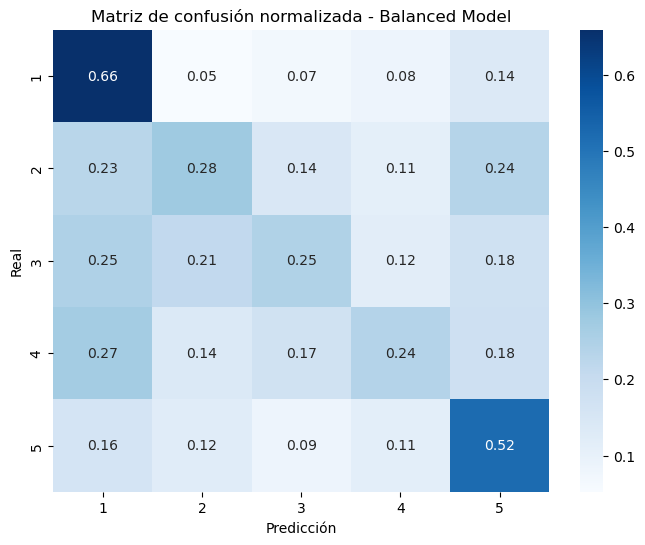

In [419]:
# Obtener las clases reales del dataset (ordenadas)
clases = sorted(y_test['newoff'].unique())  # ajusta 'newoff' a tu columna de etiquetas

# Matriz de confusión normalizada usando test
cm = confusion_matrix(y_test, y_pred_test, labels=clases, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión normalizada - Balanced Model")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

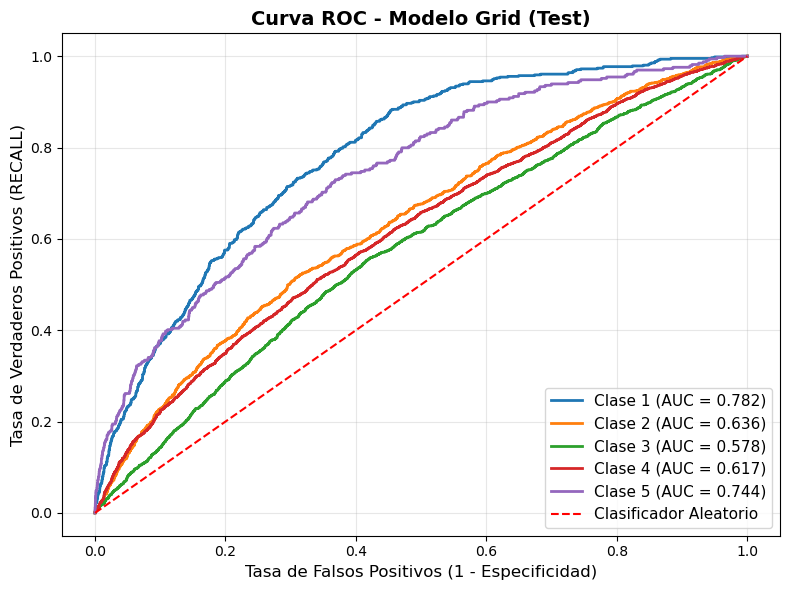

In [420]:
# Binarizar las clases (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])  # ajusta según tus clases reales

# Obtener las probabilidades de predicción del modelo
y_proba = best_model.predict_proba(x_test_scaled)

# Graficar curva ROC para cada clase
plt.figure(figsize=(8, 6))

for i, clase in enumerate([1, 2, 3, 4, 5]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'Clase {clase} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Clasificador Aleatorio')
plt.title('Curva ROC - Modelo Grid (Test)', fontsize=14, fontweight='bold')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (RECALL)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Conclusión</h3>

In [421]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           1       0.13      0.66      0.22       610
           2       0.18      0.28      0.22      1159
           3       0.26      0.25      0.25      2115
           4       0.78      0.24      0.37      6963
           5       0.08      0.52      0.14       329

    accuracy                           0.28     11176
   macro avg       0.29      0.39      0.24     11176
weighted avg       0.56      0.28      0.31     11176



El modelo optimizado con GridSearch mejora la detección de las clases minoritarias, logrando un mayor recall en ellas. Sin embargo, la precisión sigue siendo baja, lo que indica que aunque identifica más casos reales de las clases menos representadas, también comete más falsos positivos. En conjunto, el modelo logra un equilibrio más justo entre clases que los anteriores modelos.

<h3>Guardar métricas</h3>

In [376]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Regresión Logística', 'Base',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,'Si','lalala')

Métrica agregada correctamente a metrics_regresion_logistica.csv
